In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime 

#open the dataset
with open('../data/170829/cleanhouses.csv',encoding='latin-1') as f:
    df = pd.read_csv(f)

# Exploring process

1. **Understand the problem**: look at each variable and do some philosophical analysis about their meaning
2. **Univariable study**: focus on the dependent variable "price" and learn a little more about it
3. **Multivariate study**: try to understand how the dependent variable and independent variables relate
4. **Basic cleaning**: handle missing data and outliers (already done)
5. **Test assumptions**: check if the data meets the assumptions required by most multivariate techniques

In [2]:
df.columns

Index(['Unnamed: 0', 'house_type', 'address', 'area', 'sup_area', 'rooms',
       'land_area', 'monthly_fee', 'date_sold', 'price_change_pct', 'price',
       'is_condo', 'total_area', 'region', 'year', 'month', 'broker'],
      dtype='object')

## 1. Understand the problem - What can we expect?

For each variable - note down the following
- **Variable name**
- **Type** : Numerical/Categorical
- **Segment**: Building/Space/Location/Other
- **Expectation**: High/Med/Low - how much it will affect the price
- **Conclusion**: High/Med/Low - our conclusion after we give a quick look at the data
- **Comments**: Any general comments that occurred to us

| Variable Name | Type | Segment | Expectation | Conclusions | Comments |
|:-------------|:-------------|:-----|:------------- |:-------------|:-----|
| price | label | | output | | this is the output variable - may need to change to constant price |
| house_type | categorical | building | high | | maybe so high it follows a different pattern completely |
| address | string | location | low | | technically the location is super important but since this is just a string we cant use it as such, we'll use region instead |
| area | numeric | space | high | | |
| sup_area | numeric | space | med | | sup_area is almost as good as area, but high sup_area indicates maybe cellar etc. |
| rooms | numeric | space | high | | highly related to area |
| land_area | numeric | space | high | | probably higher for house than town home, land_area = 0 => is_condo |
| monthly_fee | numeric | building | med | | only available if is_condo |
| date_sold | numeric | other | med | | remove, replaced by month/year |
| price_change_pct | numeric | other | low | | remove, only available after sale |
| is_condo | categorical | building | high | | maybe combine with house type |
| total_area | numeric | space | high | | derrived from area+sup_area, we should keep either total or area/sup |
| region | categorical | other | high | | the region the house is in |
| year | categorical | other | med | | derrived from date_sold |
| month | categorical | other | med | | derrived from date_sold |
| broker | categorical | other | low | | brokers often choose houses in a specific price range so this might be dependent on expected price |

If there area lots of input variables, focus on the ones with high expectation 

# 2. Univariable study - focusing on PRICE

Let's get a feel for the variable we are trying to predict - the price of the house in thousand kr

In [3]:
df['price'].describe()

count     1154.000000
mean      5703.989298
std       2235.855818
min       1450.000000
25%       4092.500000
50%       5450.000000
75%       6998.750000
max      16900.000000
Name: price, dtype: float64

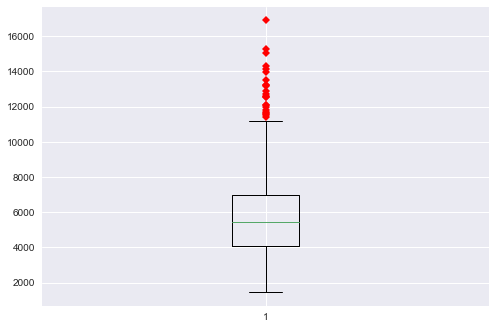

In [4]:
plt.boxplot(df['price'], 0, 'rD')
plt.show()

So the houses in our set range between 1.45 million and 16.9 million with 50% between 4 and 7 million

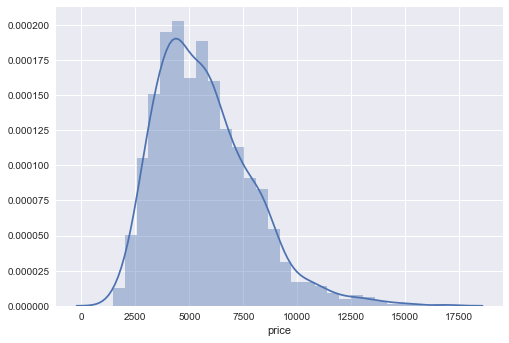

In [5]:
#histogram
sns.distplot(df['price']);
plt.show()

In [6]:
print("Skewness:", df['price'].skew())
print("Kurtosis:", df['price'].kurt())

Skewness: 0.983330315953
Kurtosis: 1.4687753884


A few other things we can see are:

- It deviates from normal distribution 
- Kurtosis < 3 shows that it is flatter (Platykurtic)
- Skewness > 0 shows that it is positively skewed (tail to the right) - but just moderately

## Comparing price to the other variables

first let's define some methods to easier plot

In [7]:
def box(indep_var, dep_var):
    data = pd.concat([df[dep_var], df[indep_var]], axis=1)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.boxplot(x=indep_var, y=dep_var, data=data, ax=ax)
    plt.show()

In [8]:
def scatter(dep_var, indep_var):
    df.plot(kind='scatter', x=indep_var, y=dep_var, s=92, alpha=0.3)
    plt.show()

### Space

We'll start with the space related variables

- area
- sup_area
- total_area
- rooms

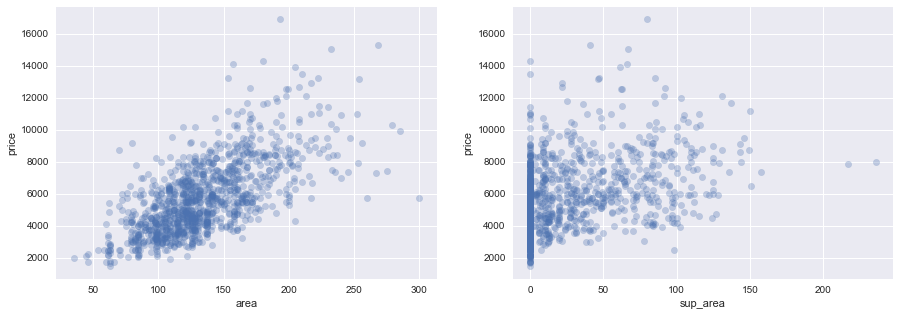

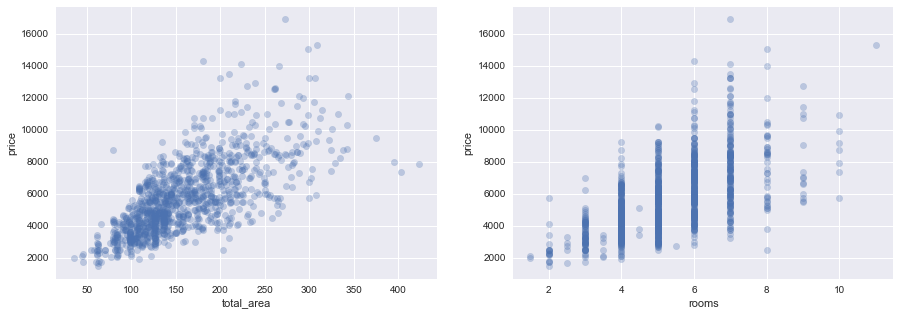

In [9]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,5))
df.plot(kind='scatter', x='area', y='price', s=42, alpha=0.3, ax=axis1)
df.plot(kind='scatter', x='sup_area', y='price', s=42, alpha=0.3, ax=axis2)
plt.show()
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,5))
df.plot(kind='scatter', x='total_area', y='price', s=42, alpha=0.3, ax=axis1)
df.plot(kind='scatter', x='rooms', y='price', s=42, alpha=0.3, ax=axis2)
plt.show()

**Area, Total Area and Rooms** all have a strong positive correlation to price
The **Sup Area** is a bit more sketchy.  

We should either use **Area + Sup_Area** as features or just **Total_Area**... I'm leaning towards **Total_Area**

**Rooms** look nice too, but... it is probably very dependent on the Area so we may have to part ways with Rooms.

PS! the **Rooms** scatter plot looks a bit weird since rooms are a discrete value 

In [10]:
#checking on some outliers - think they are houses by the lake
#df[(df['area'] < 100) & (df['price'] > 8000)]

### Land Area, Monthly Fee and Is_Condo

These variables are actually related.  

If we have a condominium we only own the right to live in the house... while the house may have land, we don't actually own the land so land area will be listed as 0 for condos

Monthly fee will be 0 for all non-condos since we don't pay a monthly fee if we own the house.

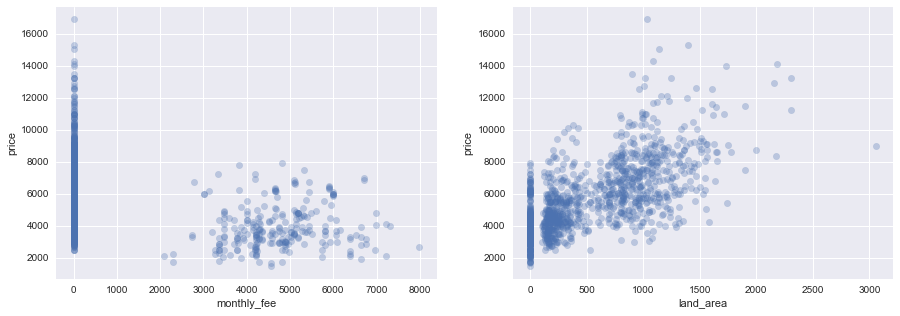

In [11]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,5))
df.plot(kind='scatter', x='monthly_fee', y='price', s=42, alpha=0.3, ax=axis1)
df.plot(kind='scatter', x='land_area', y='price', s=42, alpha=0.3, ax=axis2)
plt.show()

**Monthly fee** doesn't really show much price correlation except for the fact that the houses with a **monthly_fee** seem to not go over 8 million.

The **land_area** has a clearer positive linear trend, but it's pretty vague... again here, houses with no **land_area** stay low in price.

Interestingly enough, the trend is clearer if we look at *Villa* and *Radhus* separately, so that will be useful if we model them separately.

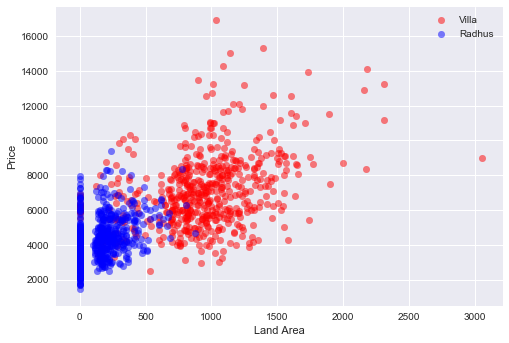

In [12]:
plt.scatter(df[df.house_type == 'Villa'].land_area, df[df.house_type == 'Villa'].price, 
            s=44, c='red', alpha=0.5, label='Villa')
plt.scatter(df[df.house_type == 'Radhus'].land_area, df[df.house_type == 'Radhus'].price, 
            s=44, c='blue', alpha=0.5, label='Radhus')
plt.xlabel('Land Area')
plt.ylabel('Price')
plt.legend()
plt.show()

We split out the is_condo into a separate column and that definitely seems to have a good correlation with price

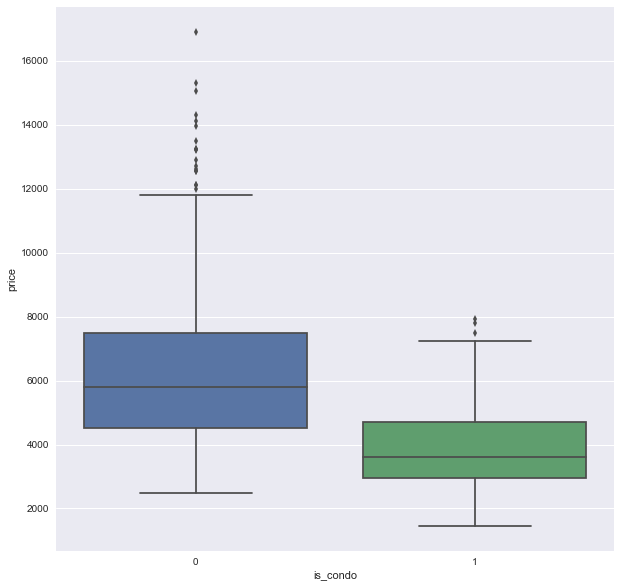

In [13]:
box('is_condo', 'price')

we'll probably drop the **monthly_fee** and continue using **land_area** and **is_condo**

To finish up here, let's make is_condo a categorical value

In [14]:
df.is_condo = pd.Categorical(df.is_condo)
df['is_condo'] = df.is_condo.cat.codes

## house_type

the house type (villa/radhus) seems to have a lot of impact on the price

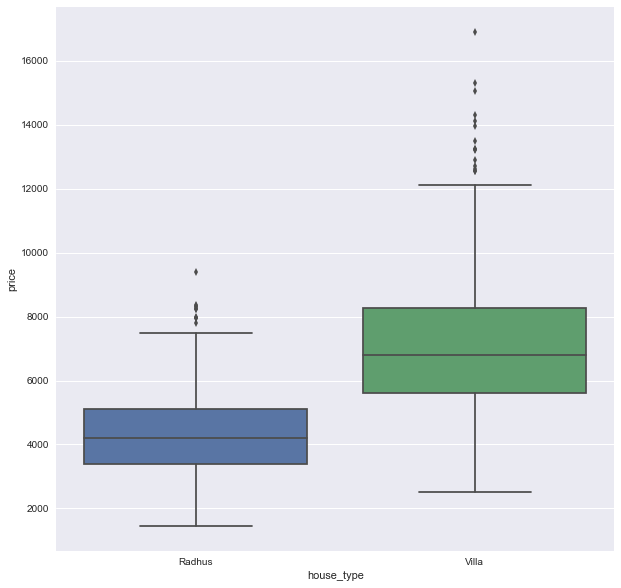

In [15]:
box('house_type', 'price')

Let's make this categorical too, and replace the strings with the categorical values

In [16]:
df.house_type = pd.Categorical(df.house_type)
df['house_type'] = df.house_type.cat.codes

In [17]:
df.sort_values(by=['Unnamed: 0'], inplace=True)
df.tail(5)

,Unnamed: 0,house_type,address,area,sup_area,rooms,land_area,monthly_fee,date_sold,price_change_pct,price,is_condo,total_area,region,year,month,broker
397,1157,0,Lomvägen 171,126.0,0.0,5.0,186.0,0.0,2013-03-22,-7.0,3010.0,0,126.0,Kärrdal,2013,3,Fastighetsbyrån
535,1158,0,Bävervägen 9,139.0,0.0,5.0,316.0,0.0,2013-03-13,4.0,5425.0,0,139.0,Tegelhagen,2013,3,Bjurfors
1067,1159,1,Skansvägen 46b,154.0,100.0,8.0,830.0,0.0,2013-03-01,5.0,7300.0,0,254.0,Edsviken,2013,3,Bjurfors
705,1160,0,Lomvägen 593,164.0,0.0,6.0,268.0,0.0,2013-02-25,0.0,3895.0,0,164.0,Kärrdal,2013,2,Fastighetsbyrån
743,1161,0,Hollywoodvägen 55,133.0,38.0,6.0,298.0,0.0,2013-02-22,-8.0,2950.0,0,171.0,Rotebro,2013,2,Bjurfors


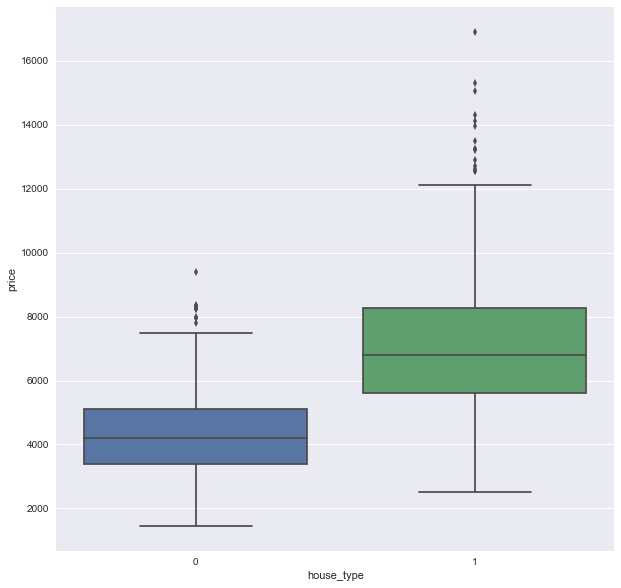

In [18]:
box('house_type', 'price')

## Date sold

We split the date sold into two parts

1. The year it was sold
2. The month it was sold

Let's check the impact of the year first

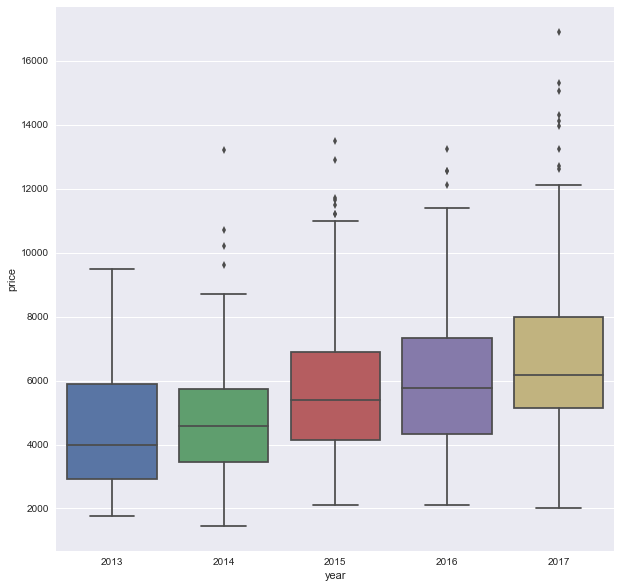

In [19]:
box('year', 'price')

The average price is steadily increasing year over year... probably a pretty linear regression for average price

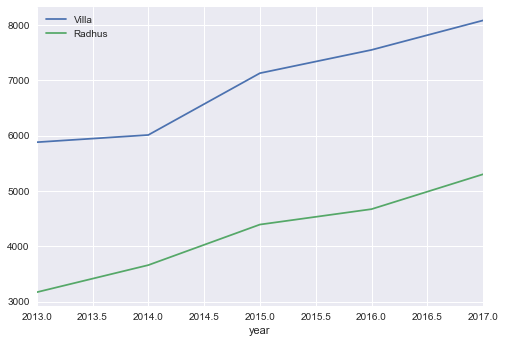

In [20]:
df_yoy_house = df[df.house_type == 1].groupby(['year'])
df_yoy_house['price'].mean().plot(kind='line', label='Villa')
df_yoy_townhome = df[df.house_type == 0].groupby(['year'])
df_yoy_townhome['price'].mean().plot(kind='line', label='Radhus')
plt.legend()
plt.show()

let's add a new column cont_month that continuously increases

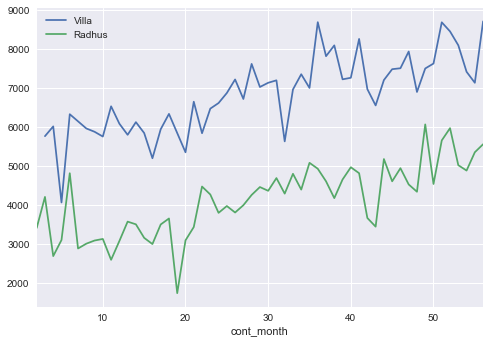

In [21]:
df['cont_month'] = df.apply(lambda row: (row['year']-2013)*12 + row['month'], axis=1)
df_mom_house = df[df.house_type == 1].groupby(['cont_month'])
df_mom_house['price'].mean().plot(kind='line', label='Villa')
df_mom_townhome = df[df.house_type == 0].groupby(['cont_month'])
df_mom_townhome['price'].mean().plot(kind='line', label='Radhus')
plt.legend()
plt.show()

There doesn't seem to be much seasonality - but there is a definite Trough around month 43 - July 2016... this is due to a new law around amortization... but then it seems like business continued as usual

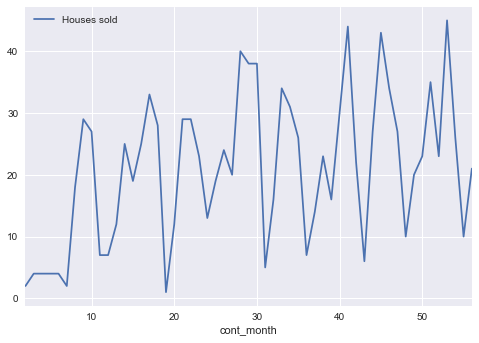

In [22]:
df.groupby(['cont_month'])['price'].count().plot(kind='line', label='Houses sold')
plt.legend()
plt.show()

The number of houses sold shows strong seasonality though, most houses are sold right before and right after the summer vacation but slows down considerably during the summer vacation  

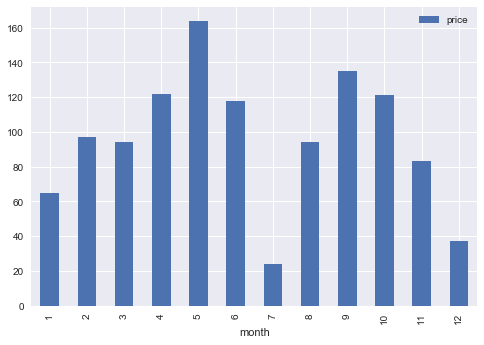

In [23]:
df.groupby(['month'])['price'].count().plot(kind='bar')
plt.legend()
plt.show()

but again, this doesn't matter since the actual month doesnt seem to affect price... best is probably to just keep the **cont_month** and drop the **year**, **month** and **date_sold**

## Region

In real-estate it is always about **LOCATION, LOCATION, LOCATION** so the region should be super important

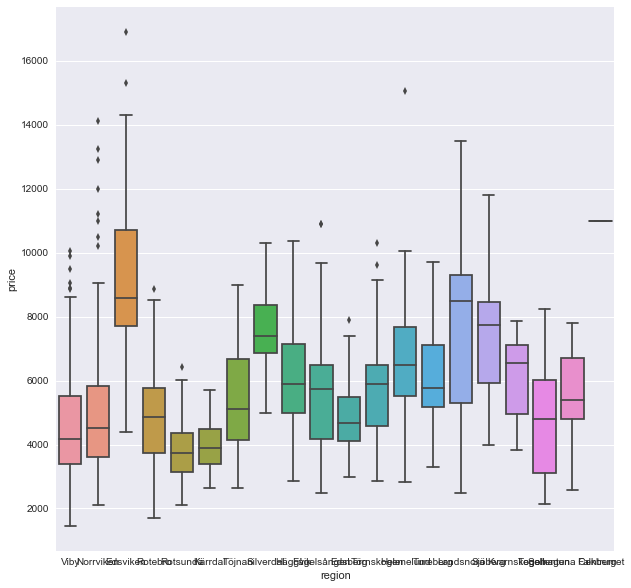

In [24]:
box('region', 'price')

In [25]:
df_by_region_count = df.groupby(['region'])['price'].agg(['mean', 'count']).sort_values(by=['mean'], ascending=False)
df_by_region_count

,mean,count
region,,
Falkberget,11000.000000,1
Edsviken,9226.960526,76
Landsnora,7930.904762,21
Silverdal,7692.428571,35
Sjöberg,7616.388889,36
Helenelund,6581.602564,78
Kvarnskogen,6211.333333,12
Tureberg,6154.166667,36
Häggvik,6044.832000,75


While some regions have too little sample size to be statistically relevant, we can definitely see that region makes a difference

The "top" regions: Falkberget, Edsviken, Landsnora, Silverdal, Sjöberg are all close to the lakes

So let's keep the **region** but make it categorical

In [26]:
df.region = pd.Categorical(df.region)
#df['region'] = df.region.cat.codes

## broker

The broker vs. price varies a lot... but now we are getting into cause and effect... i.e. will the broker you choose actually change the value of the price?  or could it just be that some brokers gravitate towards more expensive houses?  I think the latter... so I'm dropping the **broker** column

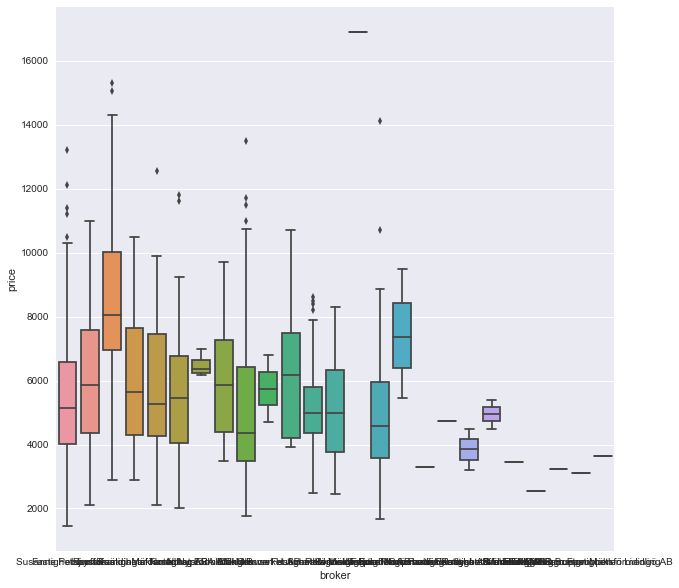

In [27]:
box('broker', 'price')

## address

The address is of course very interesting, but in machine learning terms it is just a string, unless we actually use it to give some indication about the value of the address...

If we want to get a bit fancier, we should calculate the distance to the closest lake, shopping center, school etc. and that would probably be pretty telling... but for now, just drop it.

## price_change_pct

This is the difference between the Listing Price and the Actual Selling Price.
Now, here we could do some interesting correlations, like do some brokers price lower to get people in the door etc. 

But for the purposes of predicting the price this value is useless, since it is only available after the sale is made.
So let's drop it.

# Multi-variate study - looking at how the features relate

This is pretty important since a lot of the algorithms perform pretty badly when you have a lot of features that depend on eachother... 

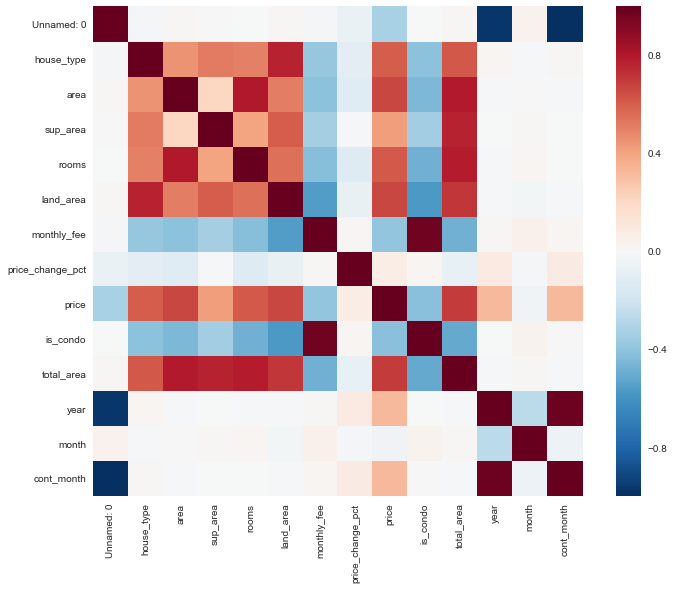

In [28]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

A high positive or a high negative correlation means that the values depend a lot on eachother.

Note: since we don't have all the values on the same scale, we can't really compare blindly but it gives us a good idea.
Note 2: correlation is only relevant where there actually exists a linear correlation

Here we can see strong correlations between year and cont_month for example, which makes sense since one is derrived from the other... we need to drop one of them.

In [29]:
corrmat

,Unnamed: 0,house_type,area,sup_area,rooms,land_area,monthly_fee,price_change_pct,price,is_condo,total_area,year,month,cont_month
Unnamed: 0,1.000000,-0.018400,0.010610,0.001960,-0.000002,0.013858,-0.017581,-0.068727,-0.326189,-0.005632,0.008212,-0.971541,0.045307,-0.997372
house_type,-0.018400,1.000000,0.446018,0.517171,0.503844,0.770755,-0.383729,-0.105824,0.607712,-0.406254,0.617355,0.016772,-0.009522,0.015273
area,0.010610,0.446018,1.000000,0.212055,0.799261,0.508492,-0.405422,-0.117755,0.666677,-0.445694,0.791088,-0.014174,0.002425,-0.014159
sup_area,0.001960,0.517171,0.212055,1.000000,0.404499,0.600598,-0.335758,-0.009459,0.417987,-0.345838,0.765545,-0.004331,0.011213,-0.001997
rooms,-0.000002,0.503844,0.799261,0.404499,1.000000,0.552415,-0.425646,-0.125619,0.613835,-0.477221,0.779388,-0.009531,0.020572,-0.005306
land_area,0.013858,0.770755,0.508492,0.600598,0.552415,1.000000,-0.559494,-0.070259,0.667531,-0.575927,0.710705,-0.008067,-0.025506,-0.014039
monthly_fee,-0.017581,-0.383729,-0.405422,-0.335758,-0.425646,-0.559494,1.000000,0.009350,-0.393566,0.971467,-0.477075,0.008479,0.047895,0.019448
price_change_pct,-0.068727,-0.105824,-0.117755,-0.009459,-0.125619,-0.070259,0.009350,1.000000,0.075925,0.022274,-0.083445,0.087483,-0.023212,0.085552
price,-0.326189,0.607712,0.666677,0.417987,0.613835,0.667531,-0.393566,0.075925,1.000000,-0.413636,0.700544,0.323586,-0.046000,0.325313
is_condo,-0.005632,-0.406254,-0.445694,-0.345838,-0.477221,-0.575927,0.971467,0.022274,-0.413636,1.000000,-0.509898,-0.001251,0.038956,0.007370


We can also zoom in and look at the ones that affect the price the most

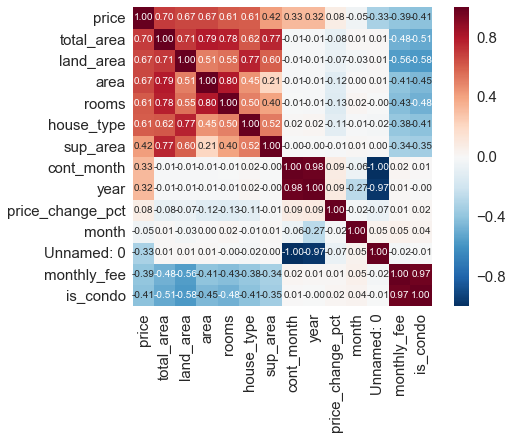

In [30]:
#saleprice correlation matrix
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

so here we can see that we should probably favor total_area over area for example

let's drop the columns we said we should drop and look again

In [31]:
try:
    del df['Unnamed: 0']
except:
    pass
try:
    del df['address']
except:
    pass
try:
    del df['monthly_fee']
except:
    pass
try:
    del df['price_change_pct']
except:
    pass
try:
    del df['year']
except:
    pass
try:
    del df['month']
except:
    pass
try:
    del df['broker']
except:
    pass
try:
    del df['date_sold']
except:
    pass

#leave these for later in case we want to use them
#try:
#    del df['rooms']
#except:
#    pass
#try:
#    del df['area']
#except:
#    pass
#try:
#    del df['sup_area']
#except:
#    pass


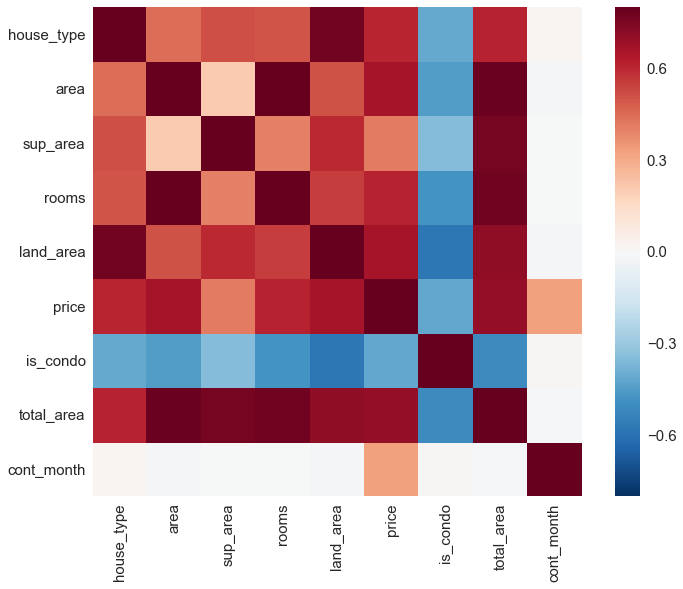

In [32]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

In [33]:
corrmat

,house_type,area,sup_area,rooms,land_area,price,is_condo,total_area,cont_month
house_type,1.000000,0.446018,0.517171,0.503844,0.770755,0.607712,-0.406254,0.617355,0.015273
area,0.446018,1.000000,0.212055,0.799261,0.508492,0.666677,-0.445694,0.791088,-0.014159
sup_area,0.517171,0.212055,1.000000,0.404499,0.600598,0.417987,-0.345838,0.765545,-0.001997
rooms,0.503844,0.799261,0.404499,1.000000,0.552415,0.613835,-0.477221,0.779388,-0.005306
land_area,0.770755,0.508492,0.600598,0.552415,1.000000,0.667531,-0.575927,0.710705,-0.014039
price,0.607712,0.666677,0.417987,0.613835,0.667531,1.000000,-0.413636,0.700544,0.325313
is_condo,-0.406254,-0.445694,-0.345838,-0.477221,-0.575927,-0.413636,1.000000,-0.509898,0.007370
total_area,0.617355,0.791088,0.765545,0.779388,0.710705,0.700544,-0.509898,1.000000,-0.010571
cont_month,0.015273,-0.014159,-0.001997,-0.005306,-0.014039,0.325313,0.007370,-0.010571,1.000000


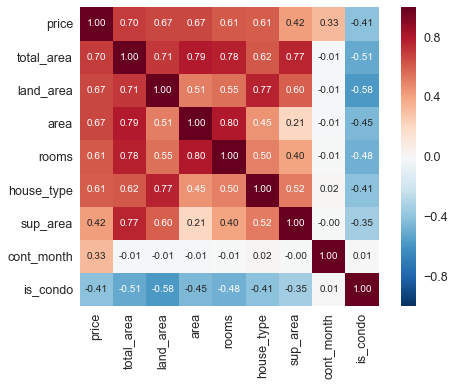

In [34]:
#saleprice correlation matrix
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [35]:
df.columns

Index(['house_type', 'area', 'sup_area', 'rooms', 'land_area', 'price',
       'is_condo', 'total_area', 'region', 'cont_month'],
      dtype='object')

re-arrange the columns to set the price last

In [36]:
cols = list(df.columns.values)
cols

['house_type',
 'area',
 'sup_area',
 'rooms',
 'land_area',
 'price',
 'is_condo',
 'total_area',
 'region',
 'cont_month']

In [37]:
df = df[['house_type',
         'area',
         'sup_area',
         'total_area',
         'rooms',
         'land_area',
         'is_condo',
         'region',
         'cont_month',
         'price']]
df.head(5)

,house_type,area,sup_area,total_area,rooms,land_area,is_condo,region,cont_month,price
643,1,155.0,0.0,155.0,6.0,1232.0,0,Viby,56,7700.0
277,0,107.0,10.0,117.0,5.0,208.0,0,Norrviken,56,4765.0
1019,1,208.0,22.0,230.0,9.0,1003.0,0,Edsviken,56,12700.0
1120,1,190.0,103.0,293.0,8.0,1389.0,0,Norrviken,56,12000.0
1114,1,198.0,91.0,289.0,7.0,1160.0,0,Edsviken,56,12100.0


# save the results

In [38]:
df.to_csv('../data/170829/cleanhouses2.csv', index=False)

## calculate the baseline RMSE

Calculate how far off we are if we just predict that all houses will cost the average price

In [39]:
mean_price = df['price'].mean()
df['prediction'] = df['price'].apply(lambda row: mean_price)

def rmse(predictions, targets):
    return np.sqrt(((predictions-targets)**2).mean())

baseline_rmse = rmse(df['price'], df['prediction'])
baseline_rmse

2234.8868659772888

2234kkr or 2.2 million kr (~€223 000) - that is pretty far off, I bet we can beat that